In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import xgboost as xgb
import warnings

In [2]:
original_df = pd.read_csv('power_tetouan_city_original.csv')
modified_df = pd.read_csv('power_tetouan_city_modified.csv')

In [3]:
df_clean = modified_df.copy()

columnas_numericas = [col for col in df_clean.columns if col not in ['DateTime', 'mixed_type_col']]

In [4]:
df_clean = df_clean.drop(columns=['mixed_type_col'])
print(f"Columna eliminada. Ahora: {df_clean.shape[1]} columnas")

Columna eliminada. Ahora: 9 columnas


In [5]:
valores_invalidos = ['error', 'invalid', '?', 'NAN', 'n/a', 'null', 'INVALID', 
                     'ERROR', ' NAN ', ' ? ', ' ERROR ', ' INVALID ', ' n/a ', ' null ']

for col in columnas_numericas:
    df_clean[col] = df_clean[col].replace(valores_invalidos, np.nan)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print(f"Valores no numéricos convertidos a NaN en todas las columnas")

Valores no numéricos convertidos a NaN en todas las columnas


In [6]:
filas_sin_datetime = df_clean['DateTime'].isna().sum()
df_clean = df_clean[df_clean['DateTime'].notna()]
print(f"{filas_sin_datetime} filas eliminadas. Ahora: {len(df_clean)} filas")

487 filas eliminadas. Ahora: 52977 filas


In [7]:
df_clean['DateTime_parsed'] = pd.to_datetime(df_clean['DateTime'], 
                                              format='%m/%d/%Y %H:%M', 
                                              errors='coerce')

filas_con_fecha_invalida = df_clean['DateTime_parsed'].isna().sum()
if filas_con_fecha_invalida > 0:
    df_clean = df_clean[df_clean['DateTime_parsed'].notna()]
    print(f"{filas_con_fecha_invalida} filas con fechas inválidas eliminadas")

df_clean = df_clean.sort_values('DateTime_parsed')
print(f"Dataset ordenado por DateTime. Ahora: {len(df_clean)} filas")

2676 filas con fechas inválidas eliminadas
Dataset ordenado por DateTime. Ahora: 50301 filas


In [8]:
duplicados_antes = df_clean.duplicated(subset=['DateTime_parsed'], keep=False).sum()
df_clean = df_clean.drop_duplicates(subset=['DateTime_parsed'], keep='first')
duplicados_eliminados = duplicados_antes - df_clean.duplicated(subset=['DateTime_parsed'], keep=False).sum()

print(f"{duplicados_eliminados} duplicados eliminados (manteniendo el primero)")
print(f"Ahora: {len(df_clean)} filas")

1832 duplicados eliminados (manteniendo el primero)
Ahora: 49385 filas


In [9]:
# Recalcular rangos desde el original (ya se hizo en Fase 2, aquí solo aplicamos)
rangos_calculados = {}
for col in columnas_numericas:
    valores_orig = pd.to_numeric(original_df[col], errors='coerce')
    q1 = valores_orig.quantile(0.25)
    q3 = valores_orig.quantile(0.75)
    iqr = q3 - q1
    lower_fence = max(0, q1 - 3 * iqr)
    upper_fence = q3 + 3 * iqr
    rangos_calculados[col] = (lower_fence, upper_fence)

outliers_por_columna = {}
for col, (min_val, max_val) in rangos_calculados.items():
    outliers = ((df_clean[col] < min_val) | (df_clean[col] > max_val)) & df_clean[col].notna()
    num_outliers = outliers.sum()
    outliers_por_columna[col] = num_outliers
    
    if num_outliers > 0:
        print(f"   • {col}: {num_outliers} outliers extremos → convertidos a NaN")
        df_clean.loc[outliers, col] = np.nan

print(f"\nTotal de outliers convertidos a NaN: {sum(outliers_por_columna.values())}")

   • Temperature: 495 outliers extremos → convertidos a NaN
   • Humidity: 521 outliers extremos → convertidos a NaN
   • Wind Speed: 328 outliers extremos → convertidos a NaN
   • general diffuse flows: 125 outliers extremos → convertidos a NaN
   • diffuse flows: 1875 outliers extremos → convertidos a NaN
   • Zone 1 Power Consumption: 251 outliers extremos → convertidos a NaN
   • Zone 2  Power Consumption: 227 outliers extremos → convertidos a NaN
   • Zone 3  Power Consumption: 266 outliers extremos → convertidos a NaN

Total de outliers convertidos a NaN: 4088


In [10]:
nans_por_fila = df_clean[columnas_numericas].isna().sum(axis=1)

umbral_nans = 4
filas_antes = len(df_clean)
df_clean = df_clean[nans_por_fila < umbral_nans]
filas_eliminadas = filas_antes - len(df_clean)

print(f"\n{filas_eliminadas} filas eliminadas (≥{umbral_nans} NaNs)")
print(f"Ahora: {len(df_clean)} filas")


4 filas eliminadas (≥4 NaNs)
Ahora: 49381 filas


In [11]:
df_clean = df_clean.drop(columns=['DateTime_parsed'])
df_clean = df_clean.reset_index(drop=True)

In [12]:
df_clean["DateTime"] = pd.to_datetime(df_clean["DateTime"], errors="coerce")

In [13]:
df_clean.set_index("DateTime", inplace=True)

In [48]:
df_clean.dropna(inplace=True)

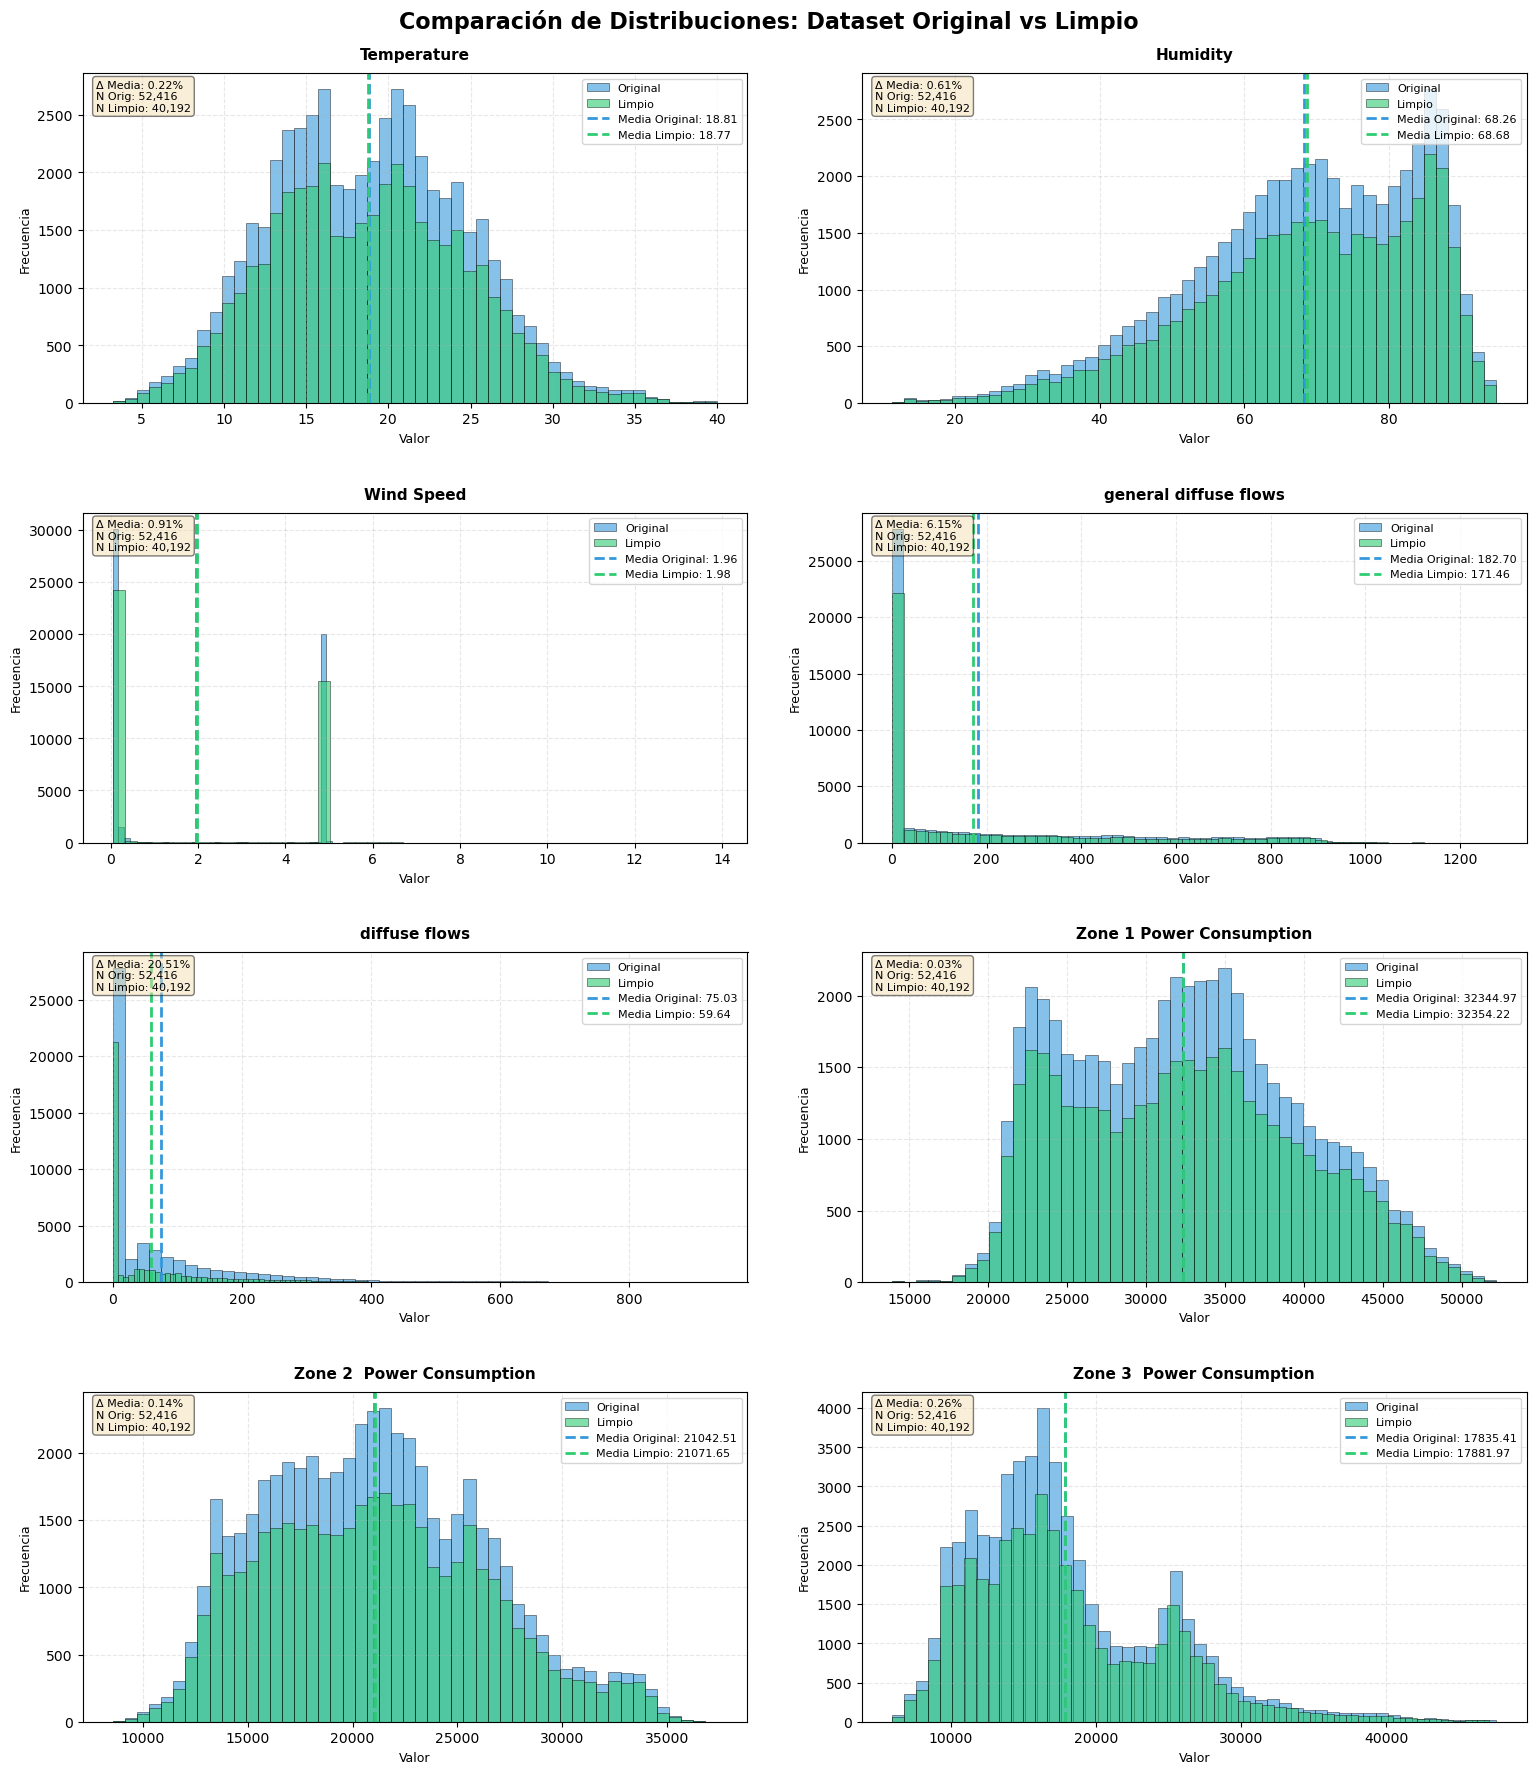

In [49]:
# Preparar datos del original
df_original_numeric = original_df.copy()
for col in columnas_numericas:
    df_original_numeric[col] = pd.to_numeric(df_original_numeric[col], errors='coerce')

# Colores
color_original = '#3498db'
color_limpio = '#2ecc71'

# GRÁFICO 1: Histogramas superpuestos
fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    datos_original = df_original_numeric[col].dropna()
    datos_limpio = df_clean[col].dropna()
    
    ax.hist(datos_original, bins=50, alpha=0.6, label='Original', 
            color=color_original, edgecolor='black', linewidth=0.5)
    ax.hist(datos_limpio, bins=50, alpha=0.6, label='Limpio', 
            color=color_limpio, edgecolor='black', linewidth=0.5)
    
    ax.axvline(datos_original.mean(), color=color_original, 
               linestyle='--', linewidth=2, label=f'Media Original: {datos_original.mean():.2f}')
    ax.axvline(datos_limpio.mean(), color=color_limpio, 
               linestyle='--', linewidth=2, label=f'Media Limpio: {datos_limpio.mean():.2f}')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Valor', fontsize=9)
    ax.set_ylabel('Frecuencia', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    diff_pct = abs((datos_limpio.mean() - datos_original.mean()) / datos_original.mean() * 100)
    textstr = f'Δ Media: {diff_pct:.2f}%\nN Orig: {len(datos_original):,}\nN Limpio: {len(datos_limpio):,}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(pad=3.0)
plt.suptitle('Comparación de Distribuciones: Dataset Original vs Limpio', 
             fontsize=16, fontweight='bold', y=0.998)
# plt.savefig('distribucion_original_vs_limpio.png', dpi=300, bbox_inches='tight')
# print("Histogramas guardados como 'distribucion_original_vs_limpio.png'")
plt.show()

## Modelo Var

In [51]:
warnings.filterwarnings("ignore")

def encontrar_mejor_var(dataframe_series, lags, n_splits=5):

    best_score = float('inf')
    best_lag = 0

    print(f"Iniciando búsqueda del mejor rezago")

    for p in range(lags):
        scores = []
        
        tscv = TimeSeriesSplit(n_splits=n_splits)

        try:
            for train_index, test_index in tscv.split(dataframe_series):
                train_data = dataframe_series.iloc[train_index]
                test_data = dataframe_series.iloc[test_index]

                if len(train_data) < p:
                    continue
                    
                model = VAR(train_data)
                model_fit = model.fit(maxlags=p)
                
                lag_order = model_fit.k_ar
                forecast_input = train_data.values[-lag_order:]
                predictions = model_fit.forecast(y=forecast_input, steps=len(test_data))
                
                error = mean_squared_error(test_data.values, predictions)
                scores.append(error)

            mean_score = np.mean(scores)
            
            if mean_score < best_score:
                best_score = mean_score
                best_lag = p
                print(f"  -> Nuevo mejor rezago encontrado: {p} con RMSE = {np.sqrt(best_score):.4f}")

        except Exception as e:
            # print(f"    Rezago {p} falló: {e}")
            continue
    
    print("\nBúsqueda finalizada.")
#    print(f"Mejor número de rezagos (p): {best_lag}")
#    print(f"Mejor RMSE de Cross-Validation: {np.sqrt(best_score):.4f}")

    print("Entrenando modelo final con todos los datos...")
    final_model = VAR(dataframe_series)
    final_model_fit = final_model.fit(maxlags=best_lag)
    
    return final_model_fit, best_lag, np.sqrt(best_score)

In [52]:
train, test = train_test_split(df_clean, test_size=0.05, shuffle=False)

In [66]:
mejor_modelo_var, mejor_rezago, mejor_rmse = encontrar_mejor_var(
    dataframe_series=train,
    lags=10,
    n_splits=5
)

print("\n--- Resumen del Mejor Modelo VAR Final ---")

forecast_input_final = train.values[-mejor_rezago:]
prediccion_futura = mejor_modelo_var.forecast(y=forecast_input_final, steps=10)

df_prediccion = pd.DataFrame(
    prediccion_futura, 
    index=pd.date_range(start=train.index[-1] + pd.Timedelta(minutes=10), periods=10, freq='10min'),
    columns=train.columns
)

print("\n--- Predicción multivariada para los próximos 10 días ---")

Iniciando búsqueda del mejor rezago
  -> Nuevo mejor rezago encontrado: 1 con RMSE = 4183.8604
  -> Nuevo mejor rezago encontrado: 2 con RMSE = 4168.5385
  -> Nuevo mejor rezago encontrado: 3 con RMSE = 4165.3201
  -> Nuevo mejor rezago encontrado: 4 con RMSE = 4163.5559
  -> Nuevo mejor rezago encontrado: 5 con RMSE = 4161.2701
  -> Nuevo mejor rezago encontrado: 6 con RMSE = 4159.2963
  -> Nuevo mejor rezago encontrado: 7 con RMSE = 4158.2928
  -> Nuevo mejor rezago encontrado: 8 con RMSE = 4156.9761
  -> Nuevo mejor rezago encontrado: 9 con RMSE = 4155.6913

Búsqueda finalizada.
Entrenando modelo final con todos los datos...

--- Resumen del Mejor Modelo VAR Final ---

--- Predicción multivariada para los próximos 10 días ---


In [87]:
rmse_var_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], df_prediccion['Zone 1 Power Consumption']))
rmse_var_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], df_prediccion['Zone 2  Power Consumption']))
rmse_var_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'], df_prediccion['Zone 3  Power Consumption']))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_var_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_var_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_var_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 3015.0460
Resultados de la métrica para Zona 2:
RMSE: 2316.9545
Resultados de la métrica para Zona 3:
RMSE: 1024.2912


## Modelo XG Boost

In [54]:
def crear_caracteristicas_alta_frecuencia(df, variable_objetivo):
    df_copy = df.copy()
    
    df_copy['hora'] = df_copy.index.hour
    df_copy['minuto'] = df_copy.index.minute
    df_copy['dia_de_semana'] = df_copy.index.dayofweek
    df_copy['dia_del_ano'] = df_copy.index.dayofyear
    
    pasos_por_hora = 6
    pasos_por_dia = 24 * pasos_por_hora

    df_copy[f'lag_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(pasos_por_hora)
    df_copy[f'lag_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(pasos_por_dia)

    df_copy[f'rolling_mean_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_hora).mean()
    df_copy[f'rolling_mean_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_dia).mean()
    
    df_copy = df_copy.dropna()
    
    X = df_copy.drop(columns=[variable_objetivo])
    y = df_copy[variable_objetivo]
    
    return X, y

In [55]:
def encontrar_mejor_xgboost_random(dataframe, variable_objetivo, param_dist, n_iter, n_splits=5):

    X, y = crear_caracteristicas_alta_frecuencia(dataframe, variable_objetivo)
    
    modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1, random_state=42)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    random_search = RandomizedSearchCV(
        estimator=modelo_xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=1234
    )
    
    print(f"3. Iniciando la búsqueda aleatoria... (Probando {n_iter} combinaciones)")
    random_search.fit(X, y)
    
    print("\nBúsqueda finalizada.")
    
    best_score_rmse = -random_search.best_score_
    print(f"Mejor RMSE de Cross-Validation: {best_score_rmse:.4f}")

    best_model = random_search.best_estimator_
    
    return best_model, best_score_rmse

In [56]:
  param_distribuciones = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

In [63]:
def predecir_multiples_pasos_xgboost(modelo, df_historico, n_pasos, variable_objetivo, feature_creation_func):

    df_recursivo = df_historico.copy()
    predicciones = []

    for i in range(n_pasos):
        datos_para_features = df_recursivo.tail(200)
        X_nuevas, _ = feature_creation_func(datos_para_features, variable_objetivo)
        X_a_predecir = X_nuevas.tail(1)
        
        prediccion_actual = modelo.predict(X_a_predecir)[0]
        predicciones.append(prediccion_actual)
        
        ultima_fecha_real = df_recursivo.index[-1]
        siguiente_fecha = ultima_fecha_real + pd.Timedelta(minutes=10)
        
        nueva_fila = {}
        nueva_fila[variable_objetivo] = prediccion_actual
        for col in df_recursivo.columns:
            if col != variable_objetivo:
                nueva_fila[col] = df_recursivo[col].iloc[-1]
        
        df_nueva_fila = pd.DataFrame([nueva_fila], index=[siguiente_fecha])
        df_recursivo = pd.concat([df_recursivo, df_nueva_fila])

    fechas_prediccion = pd.date_range(start=df_historico.index[-1] + pd.Timedelta(minutes=10), periods=n_pasos, freq='10T')
    serie_predicciones = pd.Series(predicciones, index=fechas_prediccion, name='predicciones_futuras')
    
    return serie_predicciones


In [92]:
mejor_modelo_random_1, mejor_rmse_random_1 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
        variable_objetivo='Zone 1 Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1546.9256


In [93]:
predicciones_futuras_1 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_1,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 1 Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    9664.998047
2017-12-13 13:00:00    9551.095703
2017-12-13 13:10:00    9619.388672
2017-12-13 13:20:00    9593.555664
2017-12-13 13:30:00    9671.599609
2017-12-13 13:40:00    9671.599609
2017-12-13 13:50:00    9867.939453
2017-12-13 14:00:00    9837.370117
2017-12-13 14:10:00    9884.333008
2017-12-13 14:20:00    9884.333008
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


In [97]:
mejor_modelo_random_2, mejor_rmse_random_2 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 2  Power Consumption']],
        variable_objetivo='Zone 2  Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1101.5479


In [98]:
predicciones_futuras_2 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_2,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 2  Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 2  Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras_2)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    26545.042969
2017-12-13 13:00:00    26607.613281
2017-12-13 13:10:00    26836.287109
2017-12-13 13:20:00    27119.652344
2017-12-13 13:30:00    27113.875000
2017-12-13 13:40:00    27074.208984
2017-12-13 13:50:00    27050.019531
2017-12-13 14:00:00    27012.871094
2017-12-13 14:10:00    26856.796875
2017-12-13 14:20:00    26960.289062
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


In [99]:
mejor_modelo_random_3, mejor_rmse_random_3 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 3  Power Consumption']],
        variable_objetivo='Zone 3  Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1730.5629


In [100]:
predicciones_futuras_3 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_3,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 3  Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 3  Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras_3)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    9664.998047
2017-12-13 13:00:00    9551.095703
2017-12-13 13:10:00    9619.388672
2017-12-13 13:20:00    9593.555664
2017-12-13 13:30:00    9671.599609
2017-12-13 13:40:00    9671.599609
2017-12-13 13:50:00    9867.939453
2017-12-13 14:00:00    9837.370117
2017-12-13 14:10:00    9884.333008
2017-12-13 14:20:00    9884.333008
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


## Comparativo de Modelos

In [102]:
rmse_xgb_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], predicciones_futuras_1))
rmse_xgb_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], predicciones_futuras_2))
rmse_xgb_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'],  predicciones_futuras_3))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_xgb_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_xgb_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_xgb_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 278.9662
Resultados de la métrica para Zona 2:
RMSE: 1625.5182
Resultados de la métrica para Zona 3:
RMSE: 688.4826


In [103]:
rmse_var_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], df_prediccion['Zone 1 Power Consumption']))
rmse_var_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], df_prediccion['Zone 2  Power Consumption']))
rmse_var_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'], df_prediccion['Zone 3  Power Consumption']))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_var_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_var_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_var_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 3015.0460
Resultados de la métrica para Zona 2:
RMSE: 2316.9545
Resultados de la métrica para Zona 3:
RMSE: 1024.2912
